In [1]:
import xarray
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.append('/home/xiantao/code/NNwall/Diff-FSI')
import os


os.environ["CUDA_VISIBLE_DEVICES"]= "3"
nx, nz, Nt = 320, 200, 17900

u_tau = 0.045


x = np.linspace(0, 4*np.pi, nx)
z = np.linspace(0, 2*np.pi, nz)


wallp = np.load('/home/xiantao/storage/data/APGdata-180/APGchannel-0-long/channel_180_wall_pressure.npy')

/home/xiantao/anaconda3/envs/jaxwall/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
wallp = np.concatenate([wallp[:,:,0], wallp[:,:,1]], axis=0)

In [3]:
wallp.shape

(35800, 320, 200)

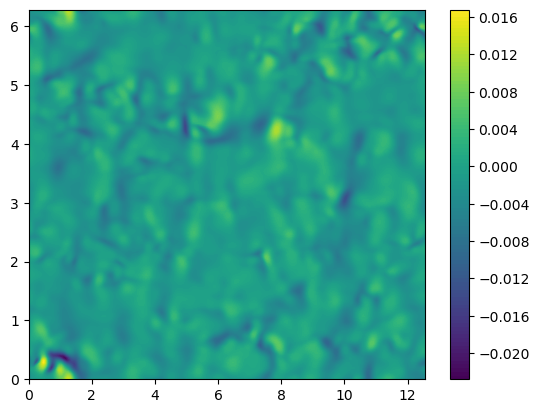

In [4]:
plt.figure()
plt.contourf(x, z, wallp[100].T, 100)
plt.colorbar()
plt.show()

# Get wall pressure fluctuation

In [5]:
dt = 0.05
scale= 1
mean = np.mean(wallp[0][0:Nt:scale])

# p_wall_sum1=np.concatenate((wallp[0][0:Nt:4],wallp[1][0:Nt:4]),axis=0)
# p_wall_sum2=np.concatenate((wallp[2][0:Nt:4],wallp[3][0:Nt:4]),axis=0)

# p_wall_sum=p_wall_sum2#jnp.concatenate((p_wall_sum1,p_wall_sum2),axis=0)

p_wall_fluct1=wallp[0:Nt:scale]-mean


In [6]:
p_wall_fluct1.shape

(17900, 320, 200)

In [7]:
# wall split
nt = 2000
overlap = 1000
time = np.arange(0, p_wall_fluct1.shape[0]+1-nt,overlap)

p_wall_fluct_slice1=[]
p_wall_fluct_slice2=[]
for t in time:
    p_wall_fluct_slice1.append(p_wall_fluct1[t:t+nt])

    
p_wall_fluct_slice_batch = np.array(p_wall_fluct_slice1)

In [8]:
# p_wall_fluct_slice_batch = p_wall_fluct_slice_batch[0:1]
p_wall_fluct_slice_batch.shape
# np.save(data_filename+'/pressure_fluctuation_2d_all_nonoverlap_t15.npy', p_wall_fluct_slice_batch)

(16, 2000, 320, 200)

In [13]:
Lx = 4* jnp.pi
Ly = 2
Lz = 2* jnp.pi

nu = 2.5e-4

nx = 320
ny = 400
nz = 200

size = (nx, ny, nz)
domain = ((0, Lx), (0, Ly),(0, Lz))

# grid=grids.Grid(size, domain=domain)

# x, y, z = grid.axes()
dx, dy, dz = Lx/nx, Ly/ny, Lz/nz
dt = dt*scale

In [11]:
class get_pressure_spectrum(object):
    def __init__(self,data, nx, nz, nt, Lx, Lz, dx, dz, dt):
        self.data=data
        self.nx=nx
        self.nz=nz
        self.nt=nt
        self.Lx=Lx
        self.Lz=Lz
        self.delta_kx = 2*jnp.pi/Lx
        self.delta_kz = 2*jnp.pi/Lz
        self.delta_w = 2*jnp.pi/(nt*dt)
        self.dt=dt
        self.dx=dx
        self.dz=dz

    def get_fft_all(self):
        p_wall_fluct_slice_batch_window = self.data*(jnp.hanning(self.nt)[None,:, None, None])
        pressure_fft = jnp.fft.fftn(p_wall_fluct_slice_batch_window, axes=(1, 2, 3)) * jnp.sqrt(8/3)/(self.nx*self.nz*self.nt)
        # pressure_fft = jnp.fft.fftshift(pressure_fft, axes=(1, 2, 3))
        pressure_power_spectrum = jnp.abs(pressure_fft)**2 / (self.delta_kx*self.delta_kz*self.delta_w)
        return pressure_power_spectrum
    
    def get_fft_x(self):
        f_x = jnp.fft.fftfreq(self.nx,self.dx)[:self.nx//2]
        pressure_power_spectrum = self.get_fft_all()
        P_x = jnp.mean(np.sum(pressure_power_spectrum, axis=(1,3))*self.delta_kz*self.delta_w, axis=0)[:self.nx//2]
        return f_x, P_x * 2
    
    def get_fft_z(self):
        f_z = jnp.fft.fftfreq(self.nz,self.dz)[:self.nz//2]
        pressure_power_spectrum = self.get_fft_all()
        P_z = jnp.mean(np.sum(pressure_power_spectrum, axis=(1,2))*self.delta_kx*self.delta_w, axis=0)[:self.nz//2]
        return f_z, P_z * 2
    
    def get_fft_t(self):
        f_t = jnp.fft.fftfreq(self.nt,self.dt)[:self.nt//2]
        pressure_power_spectrum = self.get_fft_all()
        P_t = jnp.mean(jnp.sum(pressure_power_spectrum, axis=(2,3))*self.delta_kx*self.delta_kz, axis=0)[:self.nt//2]
        return f_t, P_t * 2
    

In [11]:
# plt.figure()
# plt.contourf(x,z,p_wall_fluct_slice_batch[0,200].T, levels=100)
# plt.axis('equal')
# plt.colorbar()
# plt.show()

### Base on the definition

## Streamwise direction

In [14]:
import jax
sub_length=1
sub_sample=np.arange(0,p_wall_fluct_slice_batch.shape[0],sub_length)

P_x_sum=[None]*len(sub_sample)
i=0
for s in sub_sample:
    diff=get_pressure_spectrum(p_wall_fluct_slice_batch[s:s+sub_length], nx, nz, nt, Lx, Lz, dx, dz, dt)
    f_x, P_x_sum[i]=jax.device_get(diff.get_fft_x())
    i=i+1

P_x=np.mean(np.array(P_x_sum), axis=0)

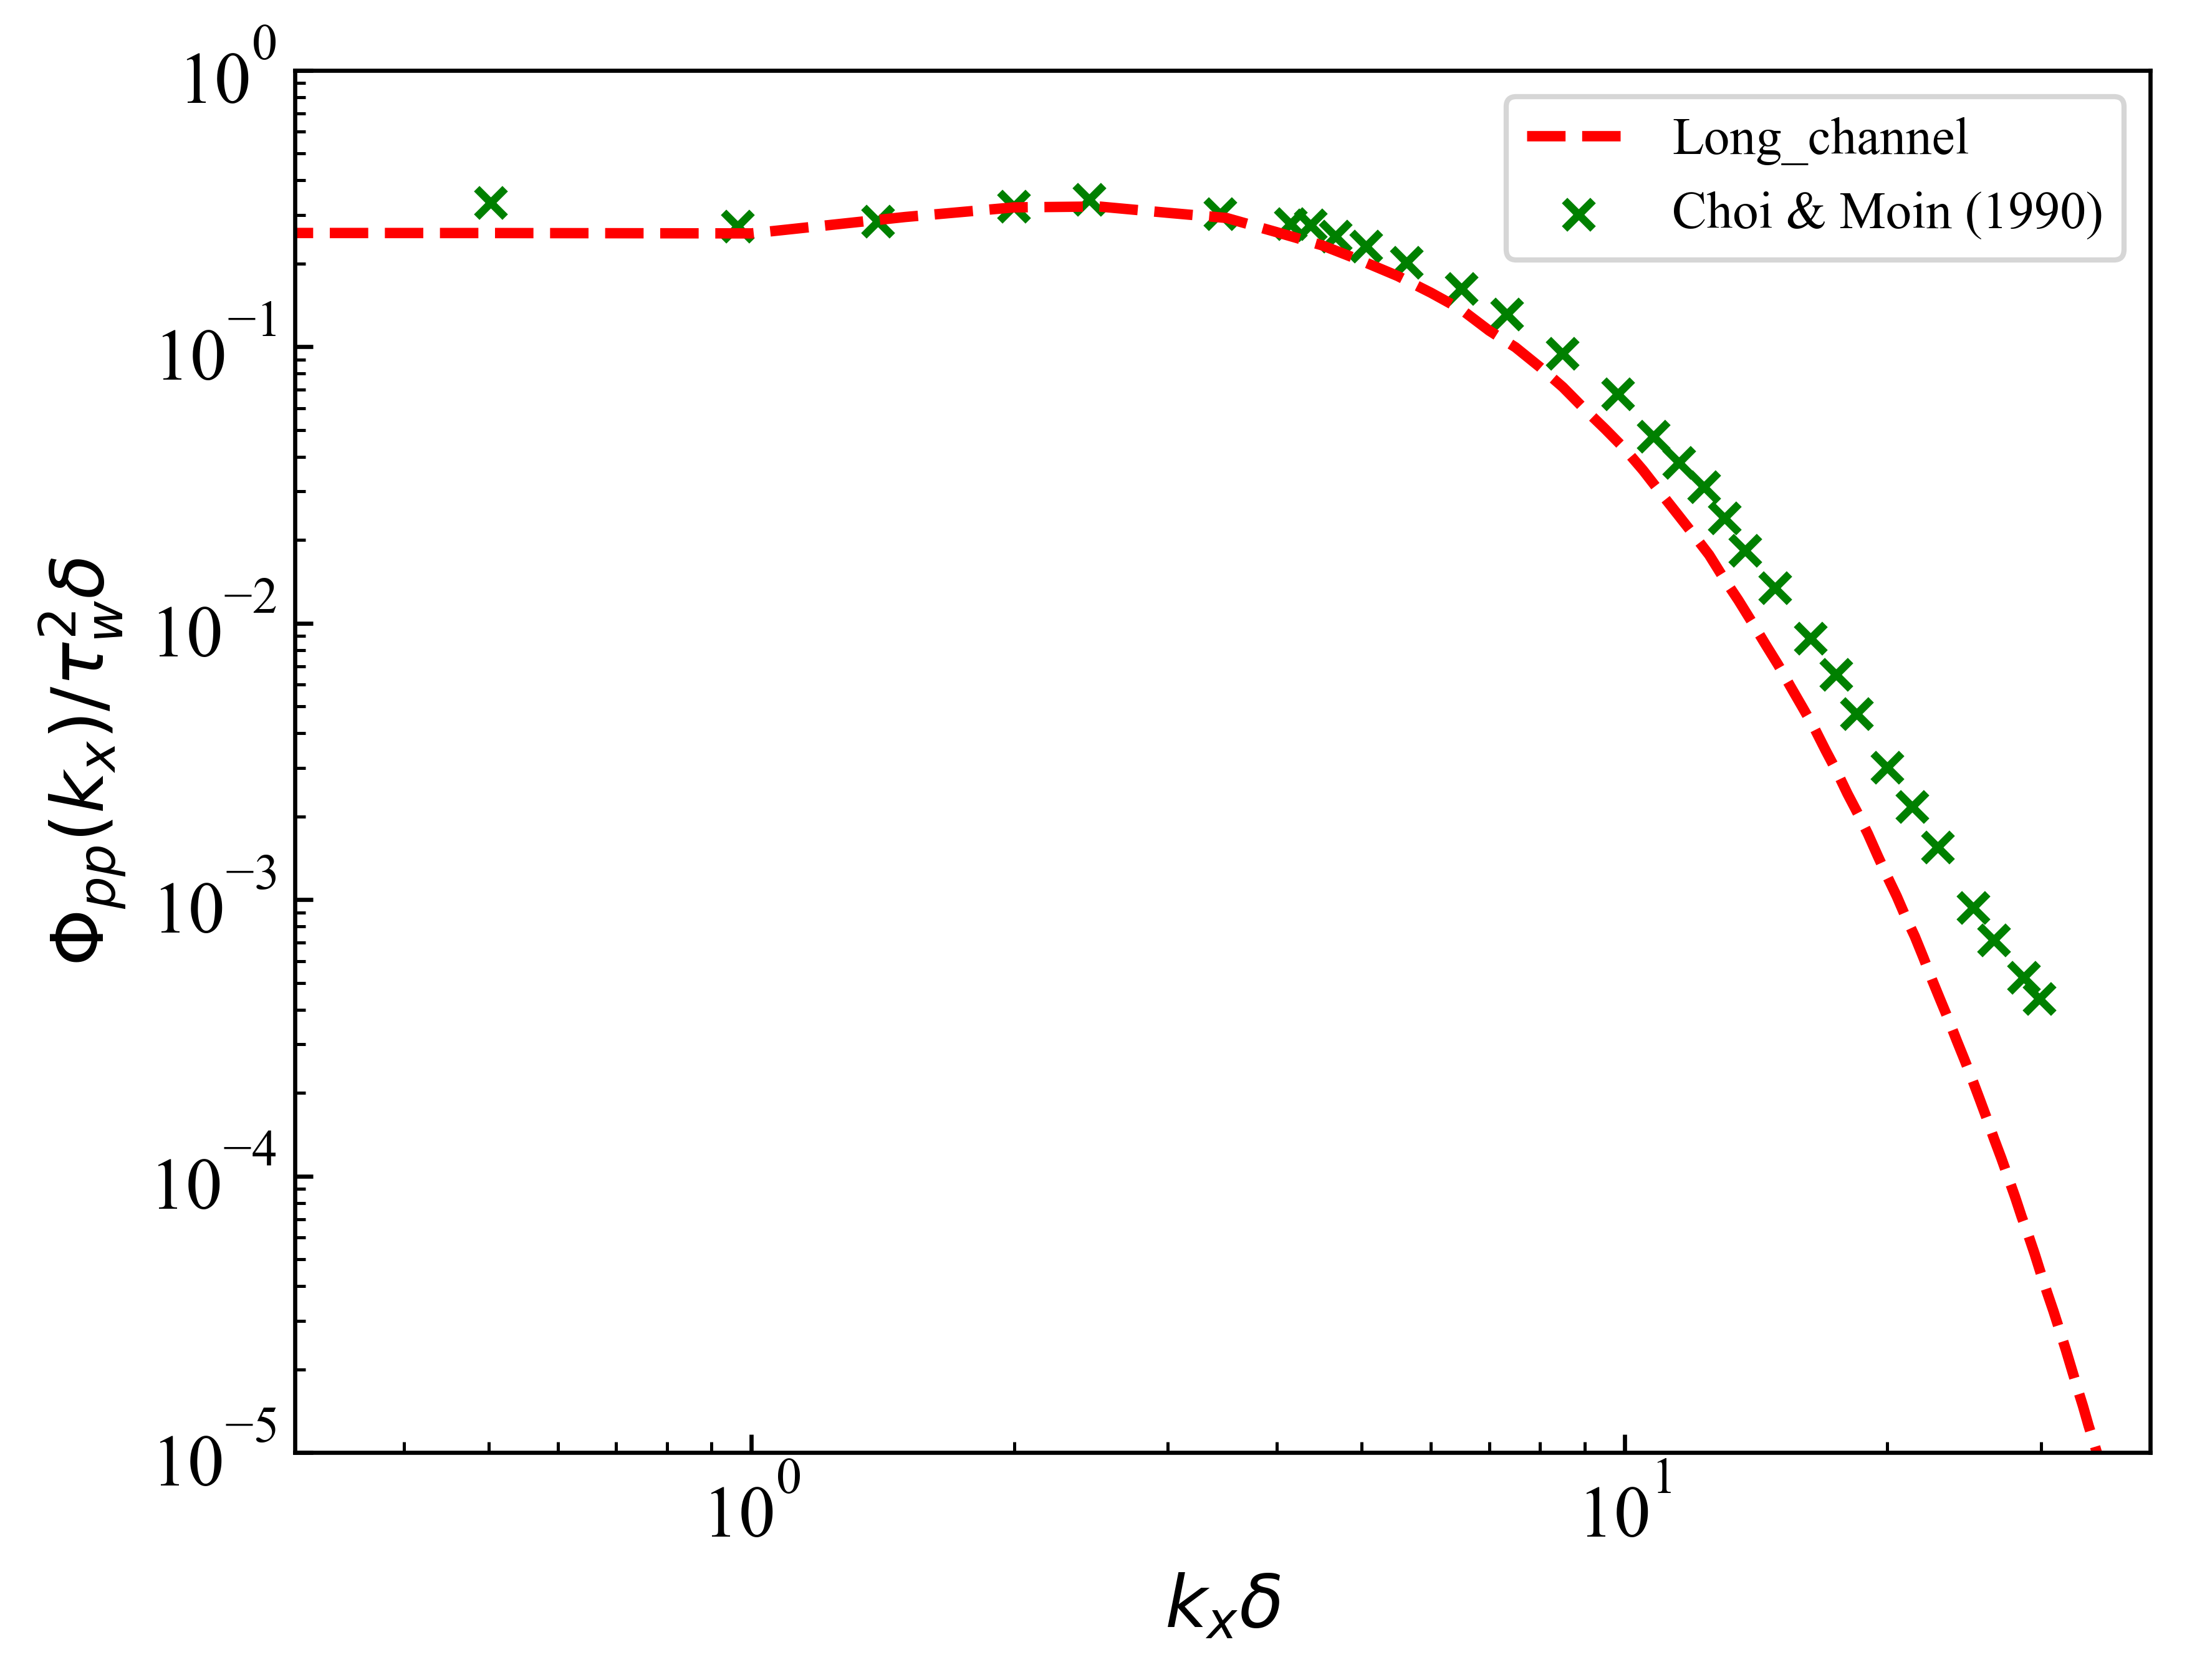

In [13]:
import jax

# normalize 
wall_unit = nu / u_tau
tau_w=u_tau**2
f_x_n = 2*jnp.pi*f_x
P_x_n = P_x/(tau_w**2)
# load ref
ref_x = np.loadtxt('/home/xiantao/code/NNwall/Diff-FSI/example/wall_pressure/p_x_180.txt')
f_x_ref, P_x_ref = ref_x[:,0], ref_x[:,1]

data_fold = "/home/xiantao/storage/data/APGdata-180/APGchannel-0"

# incompre_x = np.load(data_fold+'/p_x.npy')

hfont = {'fontname':'Times New Roman'}
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.figure(dpi=600)
# plt.plot(incompre_x[0],  incompre_x[1],  color='blue',linewidth=2,label='Incompressible')
plt.plot(f_x_n,  P_x_n, '--',color='red',linewidth=2,label='Long_channel')
plt.scatter(f_x_ref,  P_x_ref,marker='x',color='green',s=30,label='Choi & Moin (1990)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_x \delta$',fontsize = 14,**hfont)
plt.ylabel(r'$\Phi_{pp}(k_x) /\tau^2_w \delta$',fontsize = 14,**hfont)
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
plt.xlim(3e-1,40)
plt.ylim(1e-5,1e0)
plt.legend()
plt.show()

## Spanwise direction

In [14]:
P_z_sum=[None]*len(sub_sample)
i=0
for s in sub_sample:
    diff=get_pressure_spectrum(p_wall_fluct_slice_batch[s:s+sub_length], nx, nz, nt, Lx, Lz, dx, dz, dt)
    f_z, P_z_sum[i]=diff.get_fft_z()
    i=i+1

P_z=jnp.mean(jnp.array(P_z_sum), axis=0)

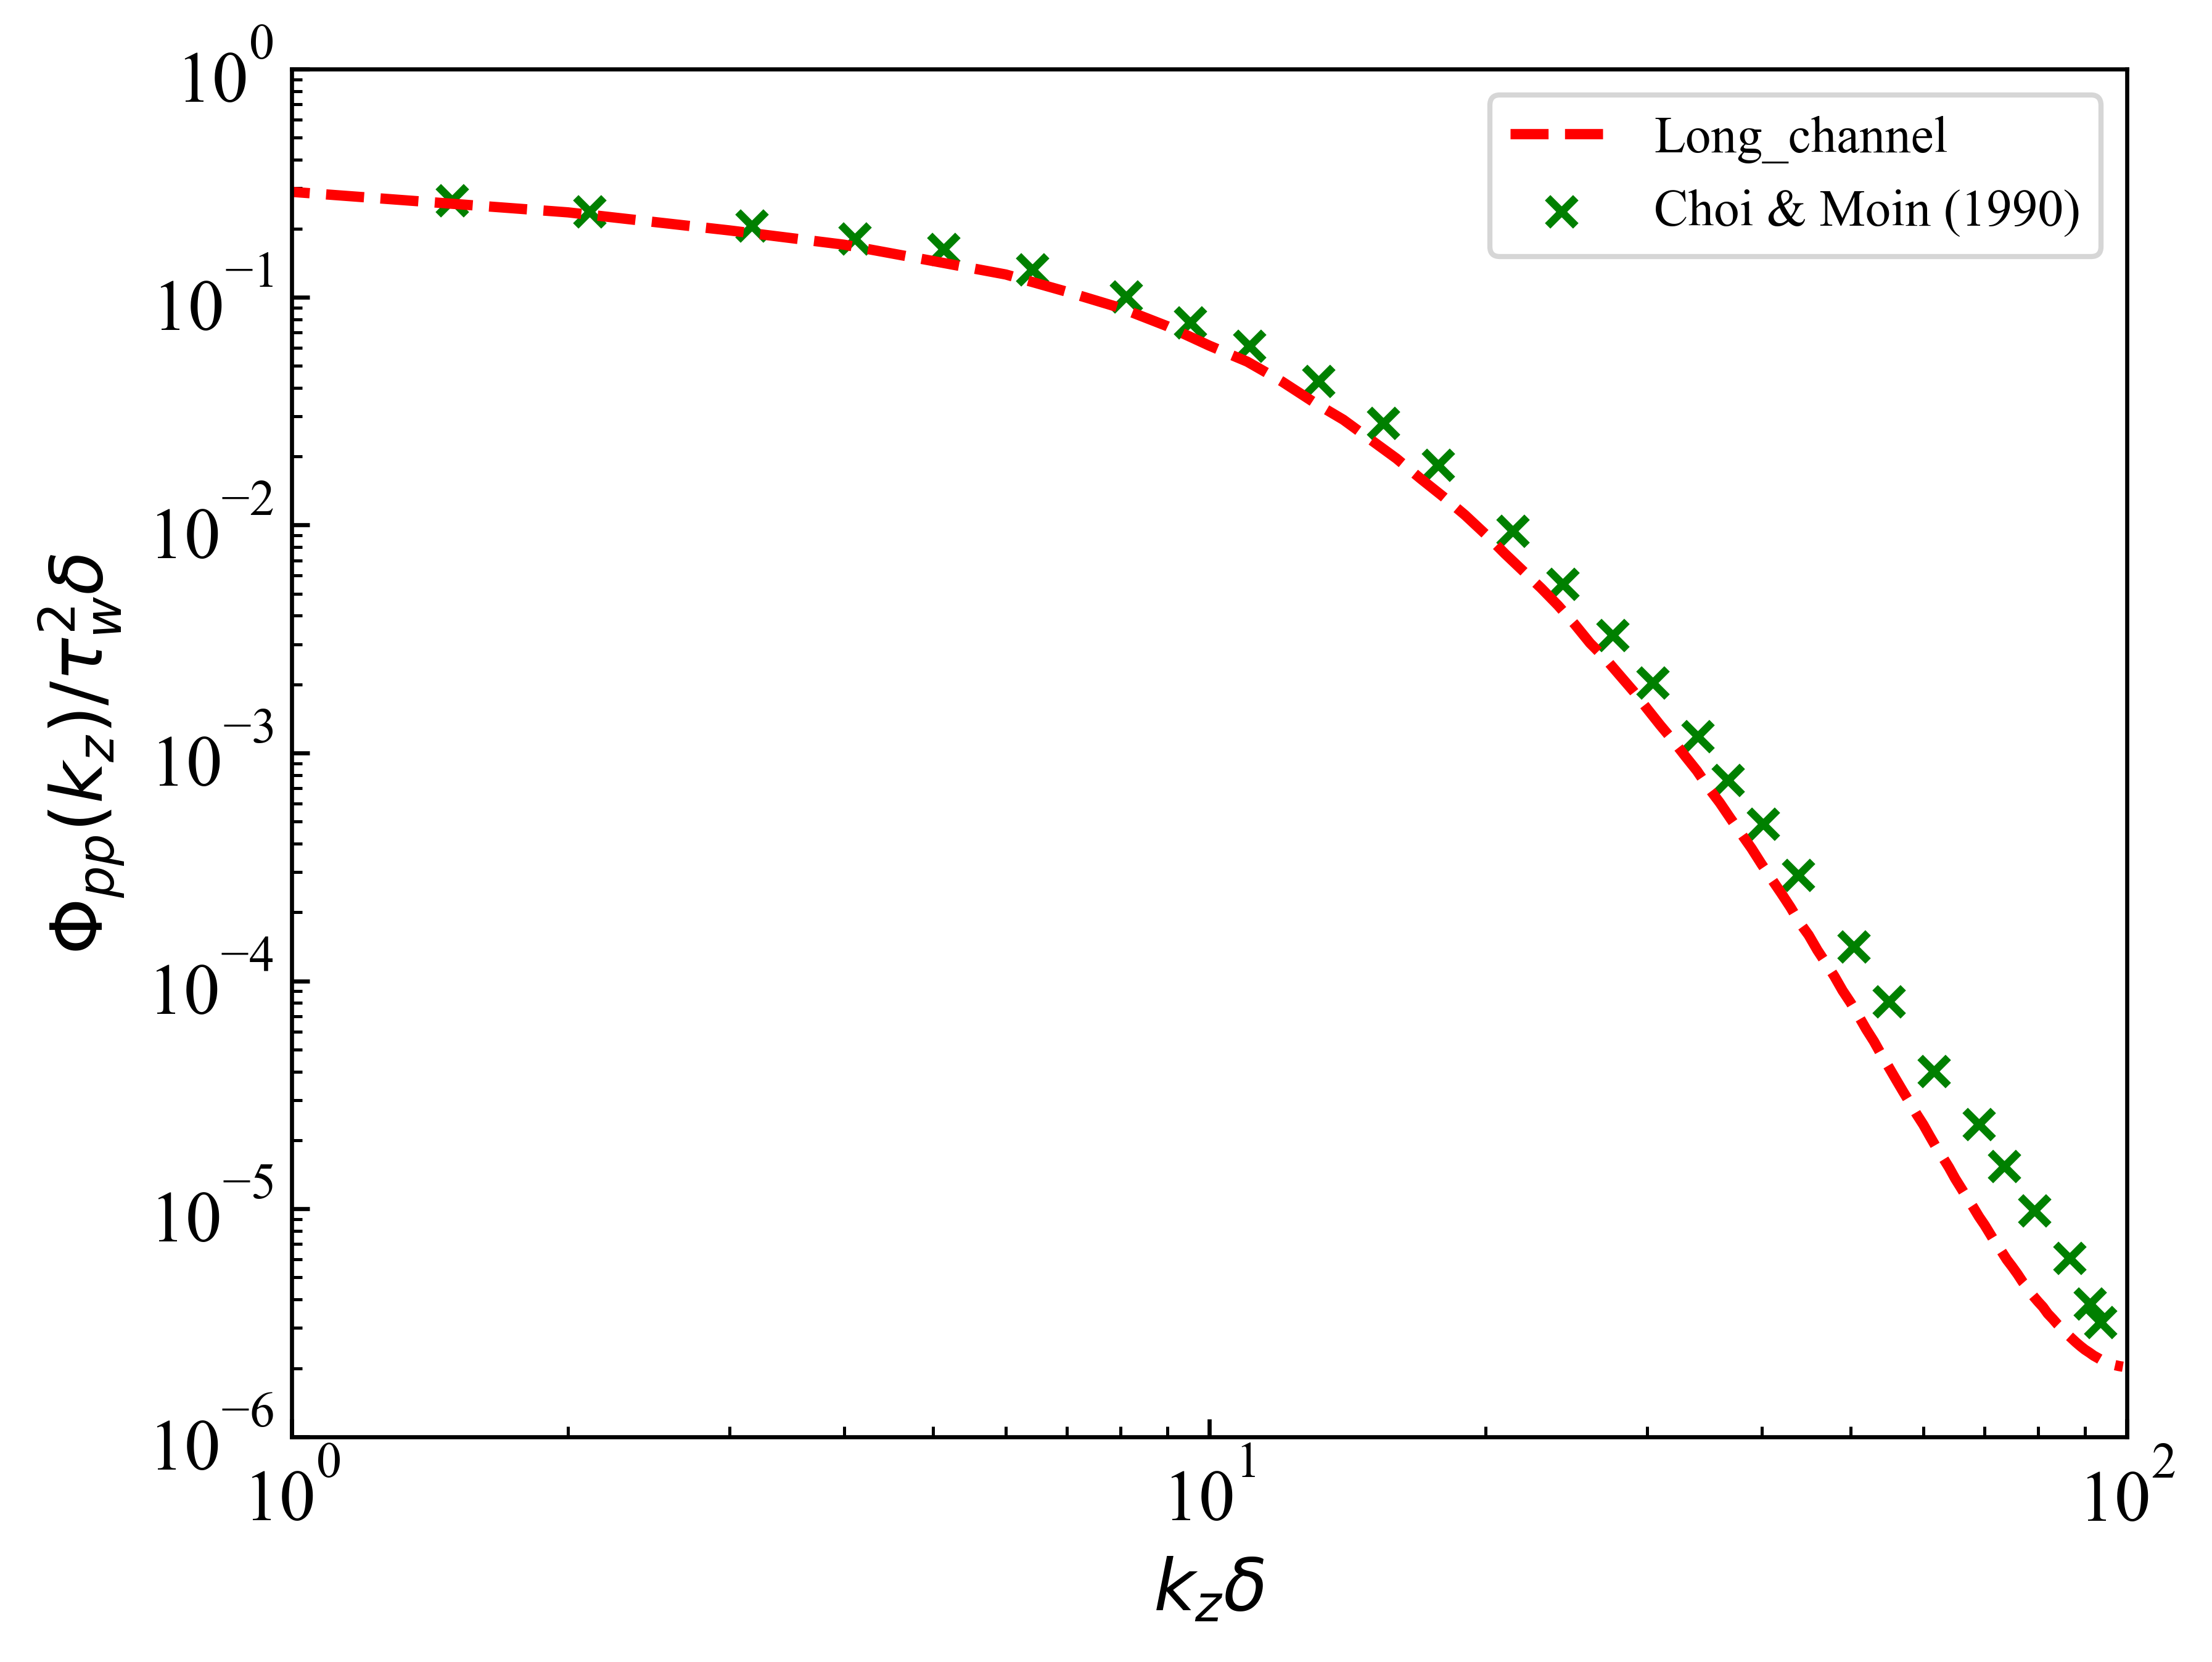

In [15]:
# normalize 
f_z_n = 2*jnp.pi*f_z
P_z_n = P_z/(tau_w)**2

# load ref
ref_z = np.loadtxt('/home/xiantao/code/NNwall/Diff-FSI/example/wall_pressure/p_z_180.txt')
f_z_ref, P_z_ref = ref_z[:,0], ref_z[:,1]
# incompre_z = np.load(data_fold+'/p_z.npy')

hfont = {'fontname':'Times New Roman'}
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.figure(dpi=600)
# plt.plot(incompre_z[0],  incompre_z[1],  color='blue',linewidth=2,label='Incompressible')
plt.plot(f_z_n,  P_z_n, '--',color='red',linewidth=2,label='Long_channel')
plt.scatter(f_z_ref,  P_z_ref,marker='x',color='green',s=30,label='Choi & Moin (1990)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_z \delta$',fontsize = 14,**hfont)
plt.ylabel(r'$\Phi_{pp}(k_z)  /\tau^2_w \delta$',fontsize = 14,**hfont)
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
plt.xlim(1,100)
plt.ylim(1e-6,1e0)
plt.legend()
plt.show()

## Time & frequency

In [16]:
import jax
sub_length=1
sub_sample=np.arange(0,p_wall_fluct_slice_batch.shape[0],sub_length)

P_t_sum=[None]*len(sub_sample)
i=0
for s in sub_sample:
    diff=get_pressure_spectrum(p_wall_fluct_slice_batch[s:s+sub_length], nx, nz, nt, Lx, Lz, dx, dz, dt)
    f_t, P_t_sum[i]=diff.get_fft_t()
    i=i+1

P_t=jnp.mean(jnp.array(P_t_sum), axis=0)

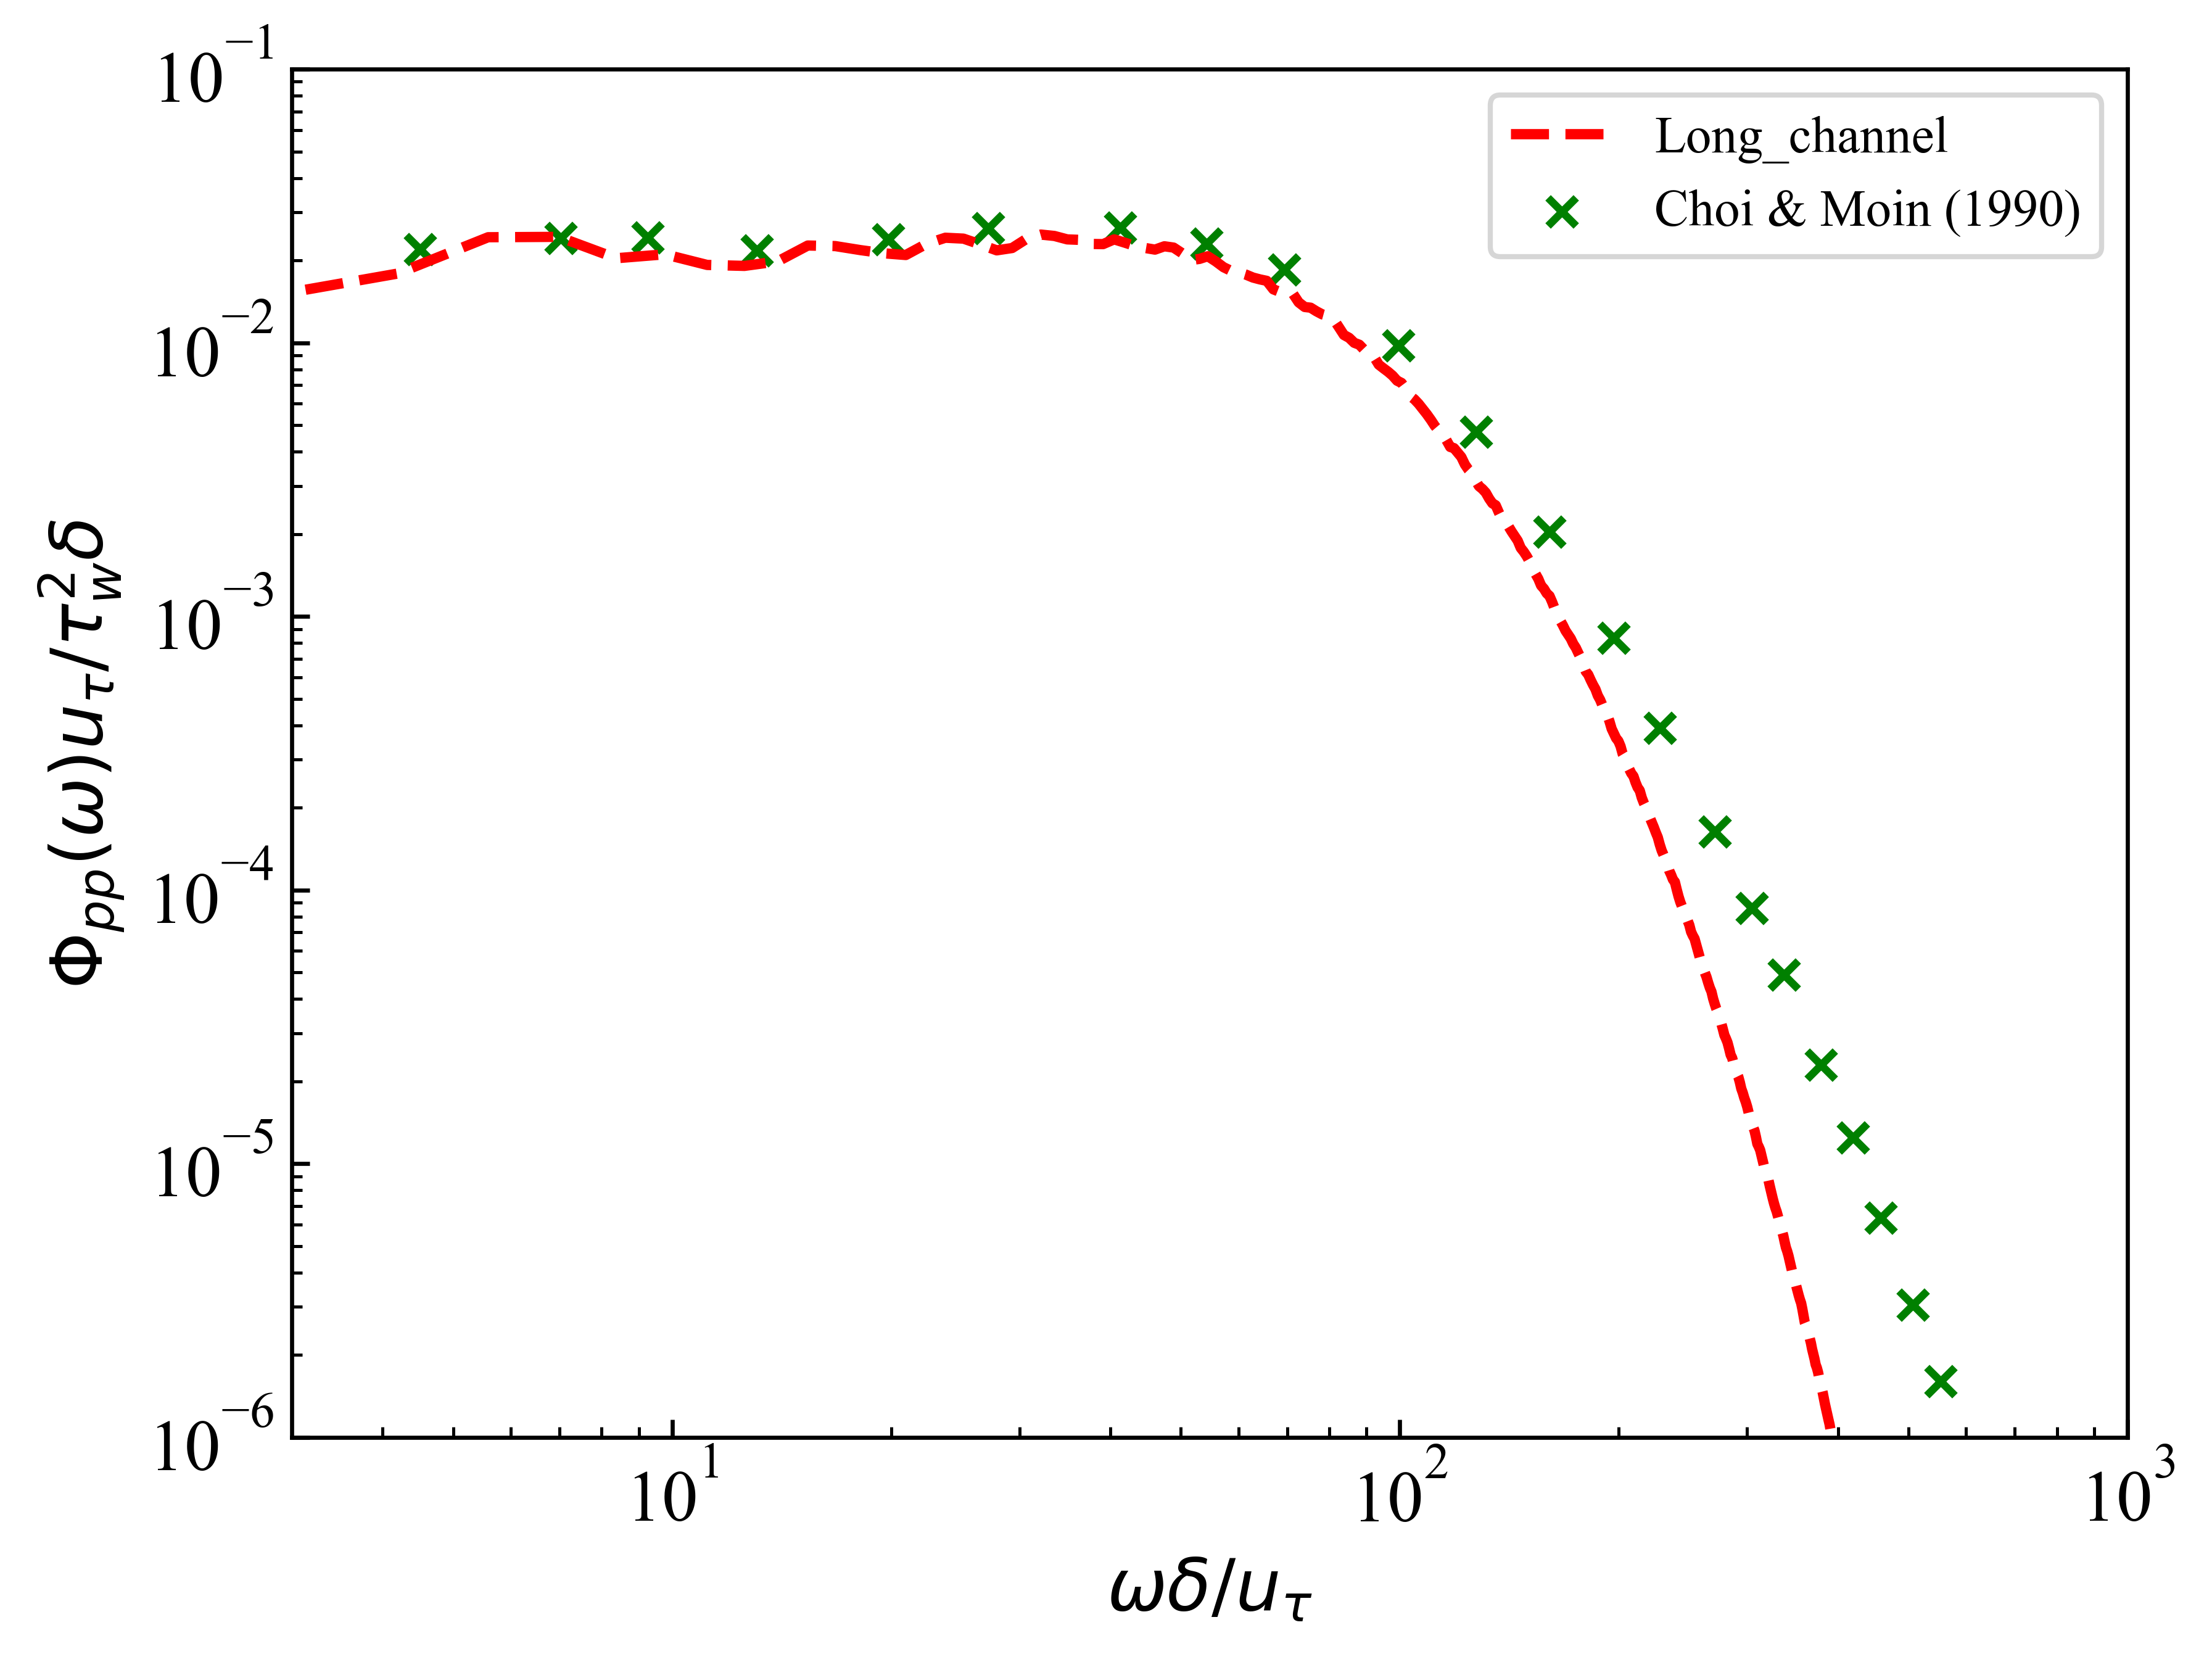

In [32]:
# normalize 
wall_unit = nu / u_tau
tau_w=u_tau**2

f_t_n = 2*jnp.pi*f_t/u_tau
P_t_n = P_t*u_tau/(tau_w**2)

# load ref
ref_t = np.loadtxt('/home/xiantao/code/NNwall/Diff-FSI/example/wall_pressure/p_t_180.txt')
f_t_ref, P_t_ref = ref_t[:,0], ref_t[:,1]
# incompre_t = np.load(data_fold+'/p_t.npy')

hfont = {'fontname':'Times New Roman'}
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.figure(dpi=600)
# plt.plot(incompre_t[0],  incompre_t[1],  color='blue',linewidth=2,label='Incompressible')
plt.plot(f_t_n,  P_t_n, '--',color='red',linewidth=2,label='Long_channel')
plt.scatter(f_t_ref,  P_t_ref ,marker='x',color='green',s=30,label='Choi & Moin (1990)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega \delta / u_{\tau}$',fontsize = 14,**hfont)
plt.ylabel(r'$\Phi_{pp}(\omega) u_{\tau}/\tau^2_w \delta$',fontsize = 14,**hfont)
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
plt.xlim(3,1e3)
plt.ylim(1e-6,1e-1)
plt.legend()
plt.show()

# Wavenumber-frequency spectrum

In [18]:
f_x_full = jnp.fft.fftshift(jnp.fft.fftfreq(nx,dx) * 2 *np.pi)
f_z_full = jnp.fft.fftshift(jnp.fft.fftfreq(nz,dz))
f_t_full = jnp.fft.fftshift(jnp.fft.fftfreq(nt,dt)* 2*jnp.pi/u_tau)

P_all_sum=[None]*len(sub_sample)
i=0
for s in sub_sample:
    diff=get_pressure_spectrum(p_wall_fluct_slice_batch[s:s+sub_length], nx, nz, nt, Lx, Lz, dx, dz, dt)
    P_all_sum[i]=diff.get_fft_all()
    i=i+1

pressure_power_spectrum = np.concatenate(P_all_sum,axis=0)

In [19]:
P_x_t = np.mean(np.sum(pressure_power_spectrum,axis=-1)*diff.delta_kz, axis=0)

P_x_t_n=P_x_t*u_tau/(tau_w**2)

# flip the P_x_t_n
P_x_t_n_flip = np.flip(jnp.fft.fftshift(P_x_t_n * 2),axis=0)

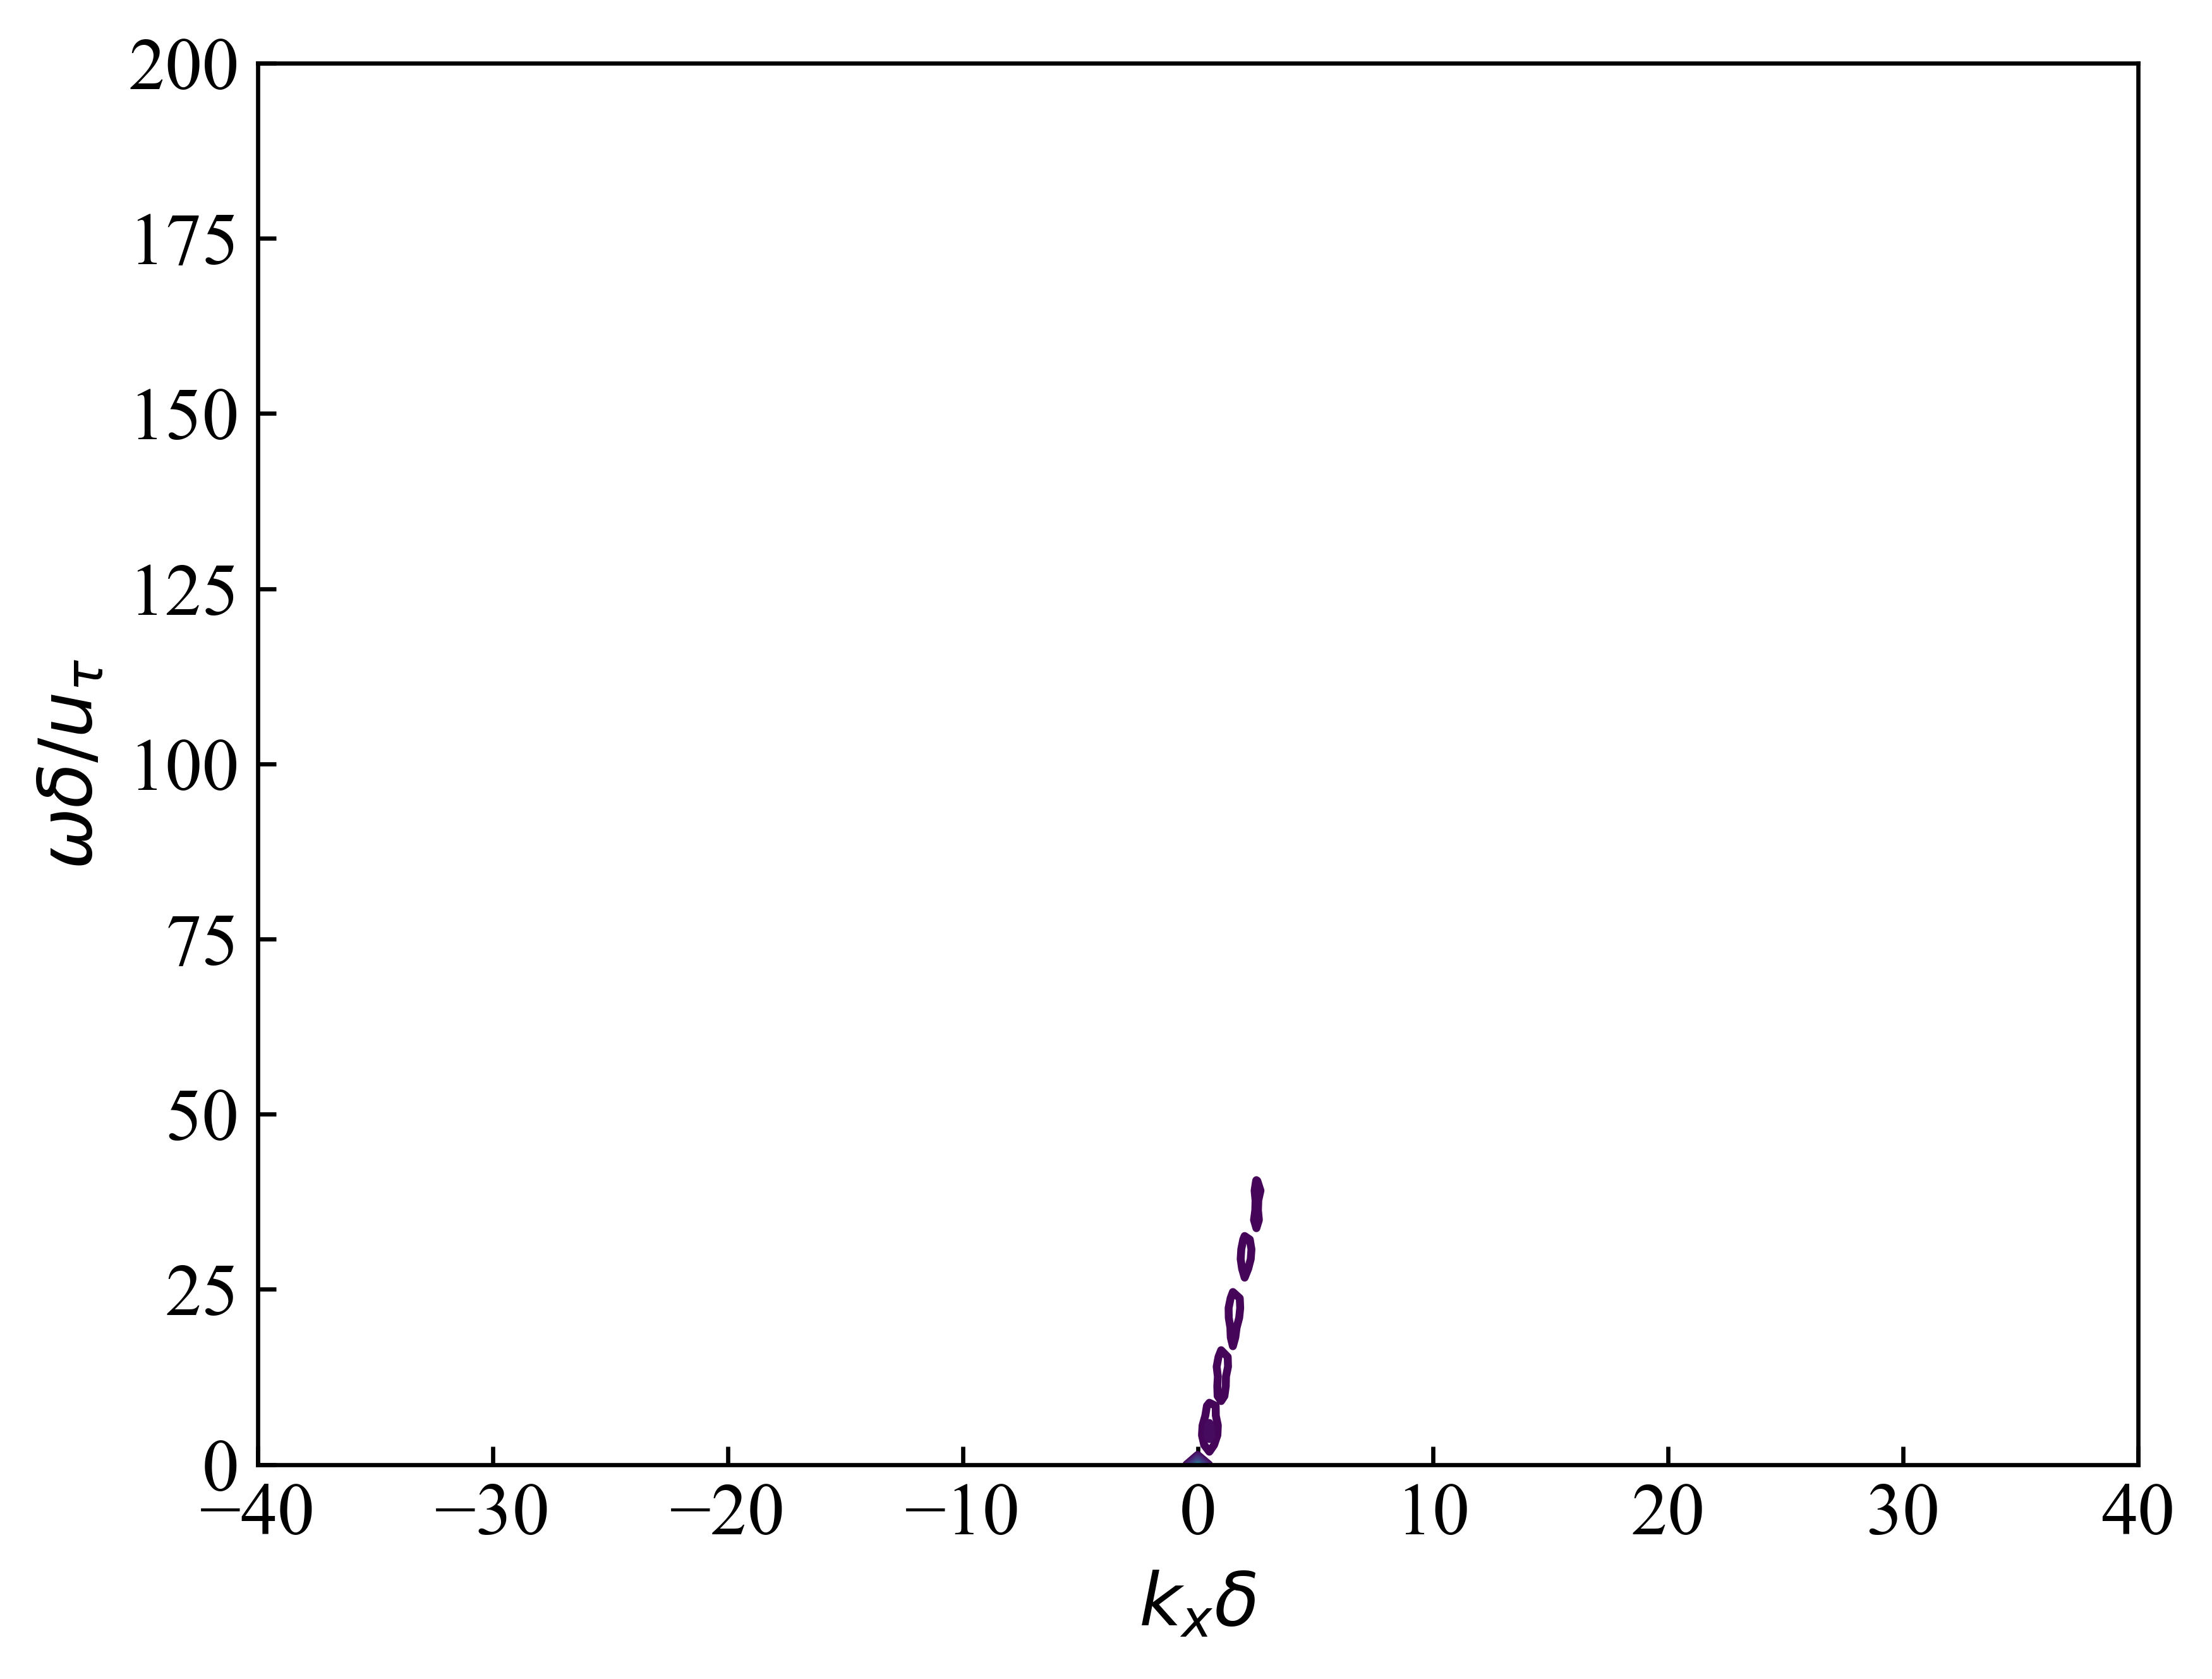

In [20]:
hfont = {'fontname':'Times New Roman'}
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.figure(dpi=600)
plt.contour(f_x_full,f_t_full,P_x_t_n_flip,levels=100)
plt.ylim([0,200])
plt.xlim([-40,40])
plt.xlabel(r'$k_x \delta$',fontsize = 14,**hfont)
plt.ylabel(r'$\omega \delta / u_{\tau}$',fontsize = 14,**hfont)
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
# plt.colorbar()
plt.show()

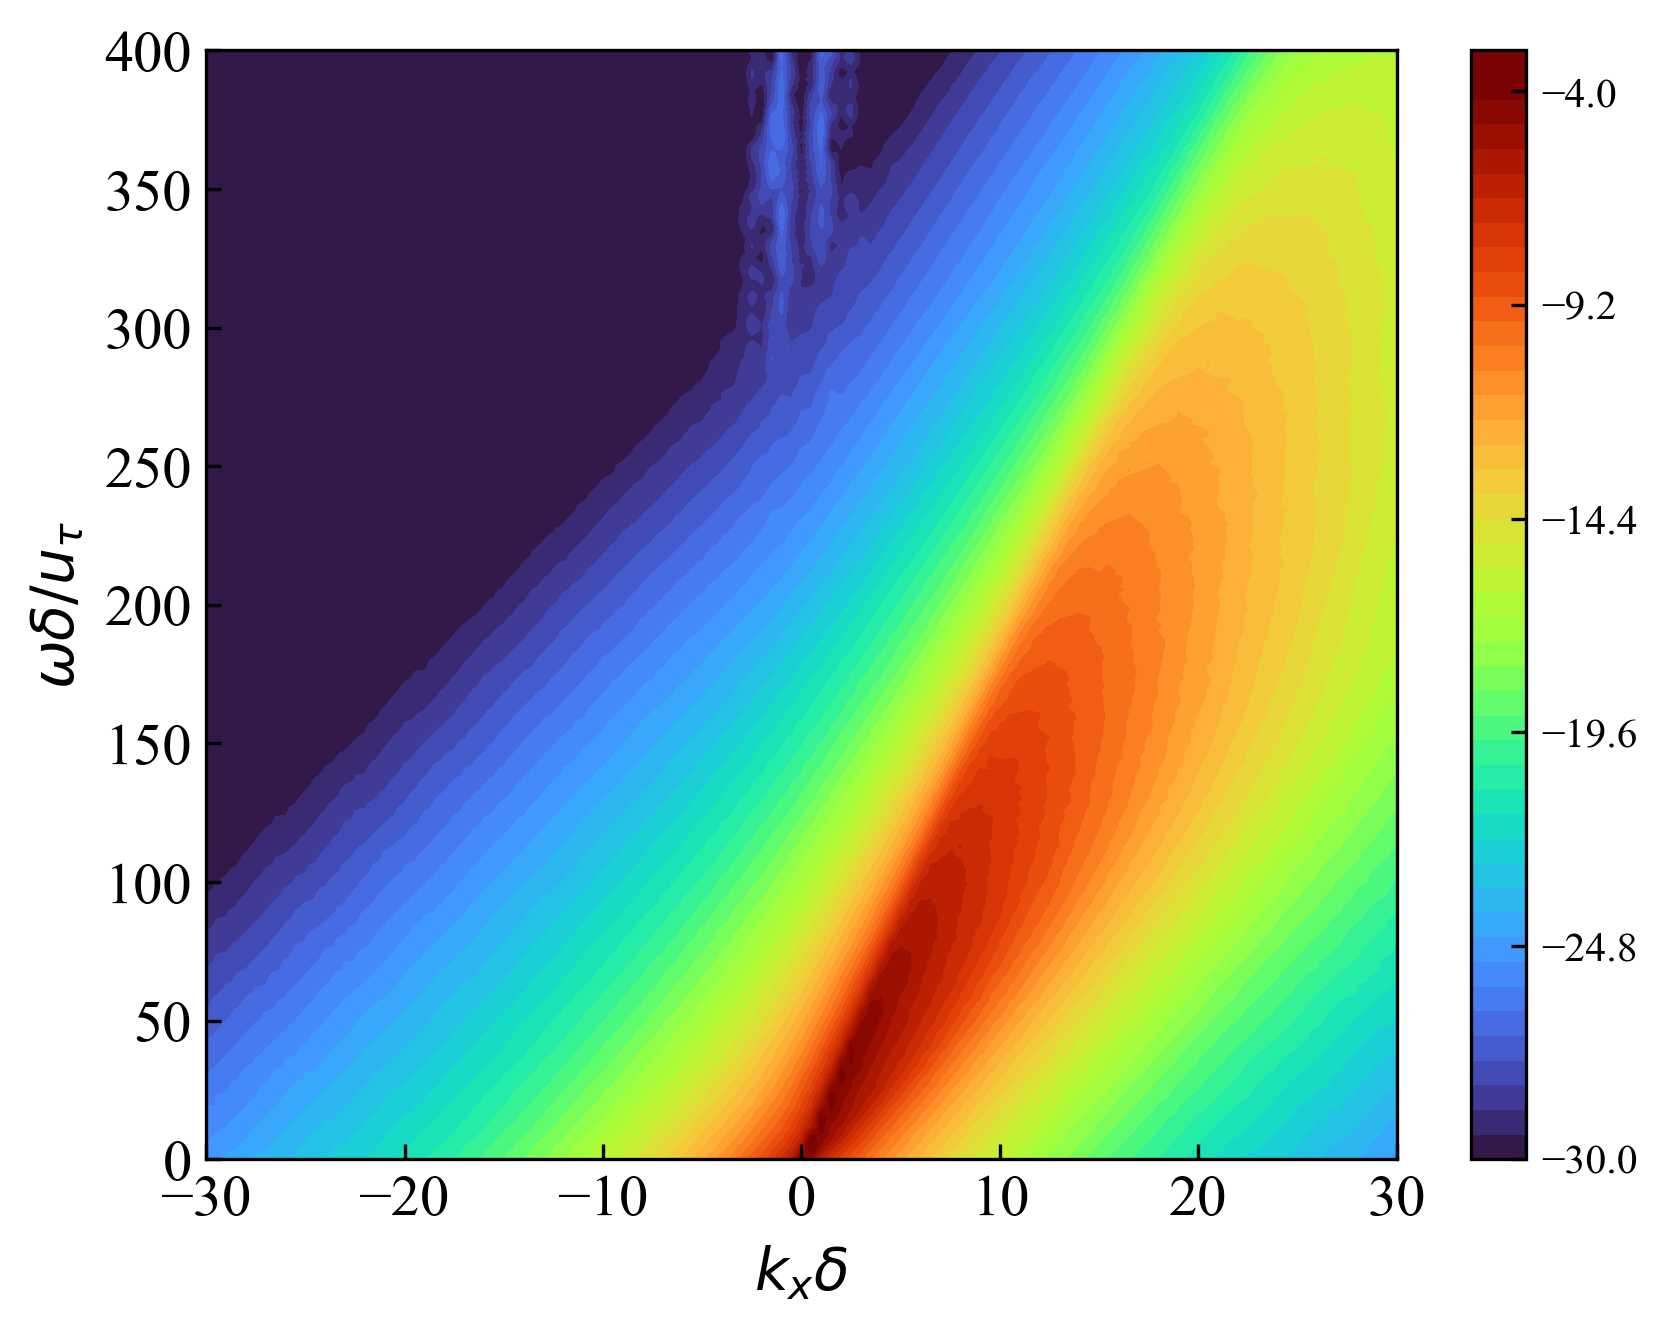

In [21]:
P_x_t_z0 = np.mean(np.sum(pressure_power_spectrum[...,0:1],axis=-1)*diff.delta_kz, axis=0)

P_x_t_n_z0=P_x_t_z0*u_tau/(tau_w**2)

# flip the P_x_t_n
P_x_t_n_flip_z0 = np.flip(jnp.fft.fftshift(P_x_t_n * 2),axis=0) #jnp.fft.fftshift(P_x_t_n * 2)

plotvalue = jnp.clip(jnp.log(P_x_t_n_flip_z0)[950:1350,50:226],-30,-3.0)

hfont = {'fontname':'Times New Roman'}
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.figure(dpi=300)
plt.contourf(f_x_full[50:226],f_t_full[950:1350],plotvalue,vmin=-30,vmax=-4.0,cmap='turbo',levels=50)
# plt.plot(np.arange(0,10,1),np.arange(0,10,1)*13,'--',color='black')
plt.ylim([0,400])
plt.xlim([-30,30])
plt.xlabel(r'$k_x \delta$',fontsize = 14,**hfont)
plt.ylabel(r'$\omega \delta / u_{\tau}$',fontsize = 14,**hfont)
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
plt.colorbar(ticks=np.linspace(-30,-4,6))
plt.show()

In [22]:
difference_array = np.absolute(f_t_n-100)
t_index_i= difference_array.argmin()

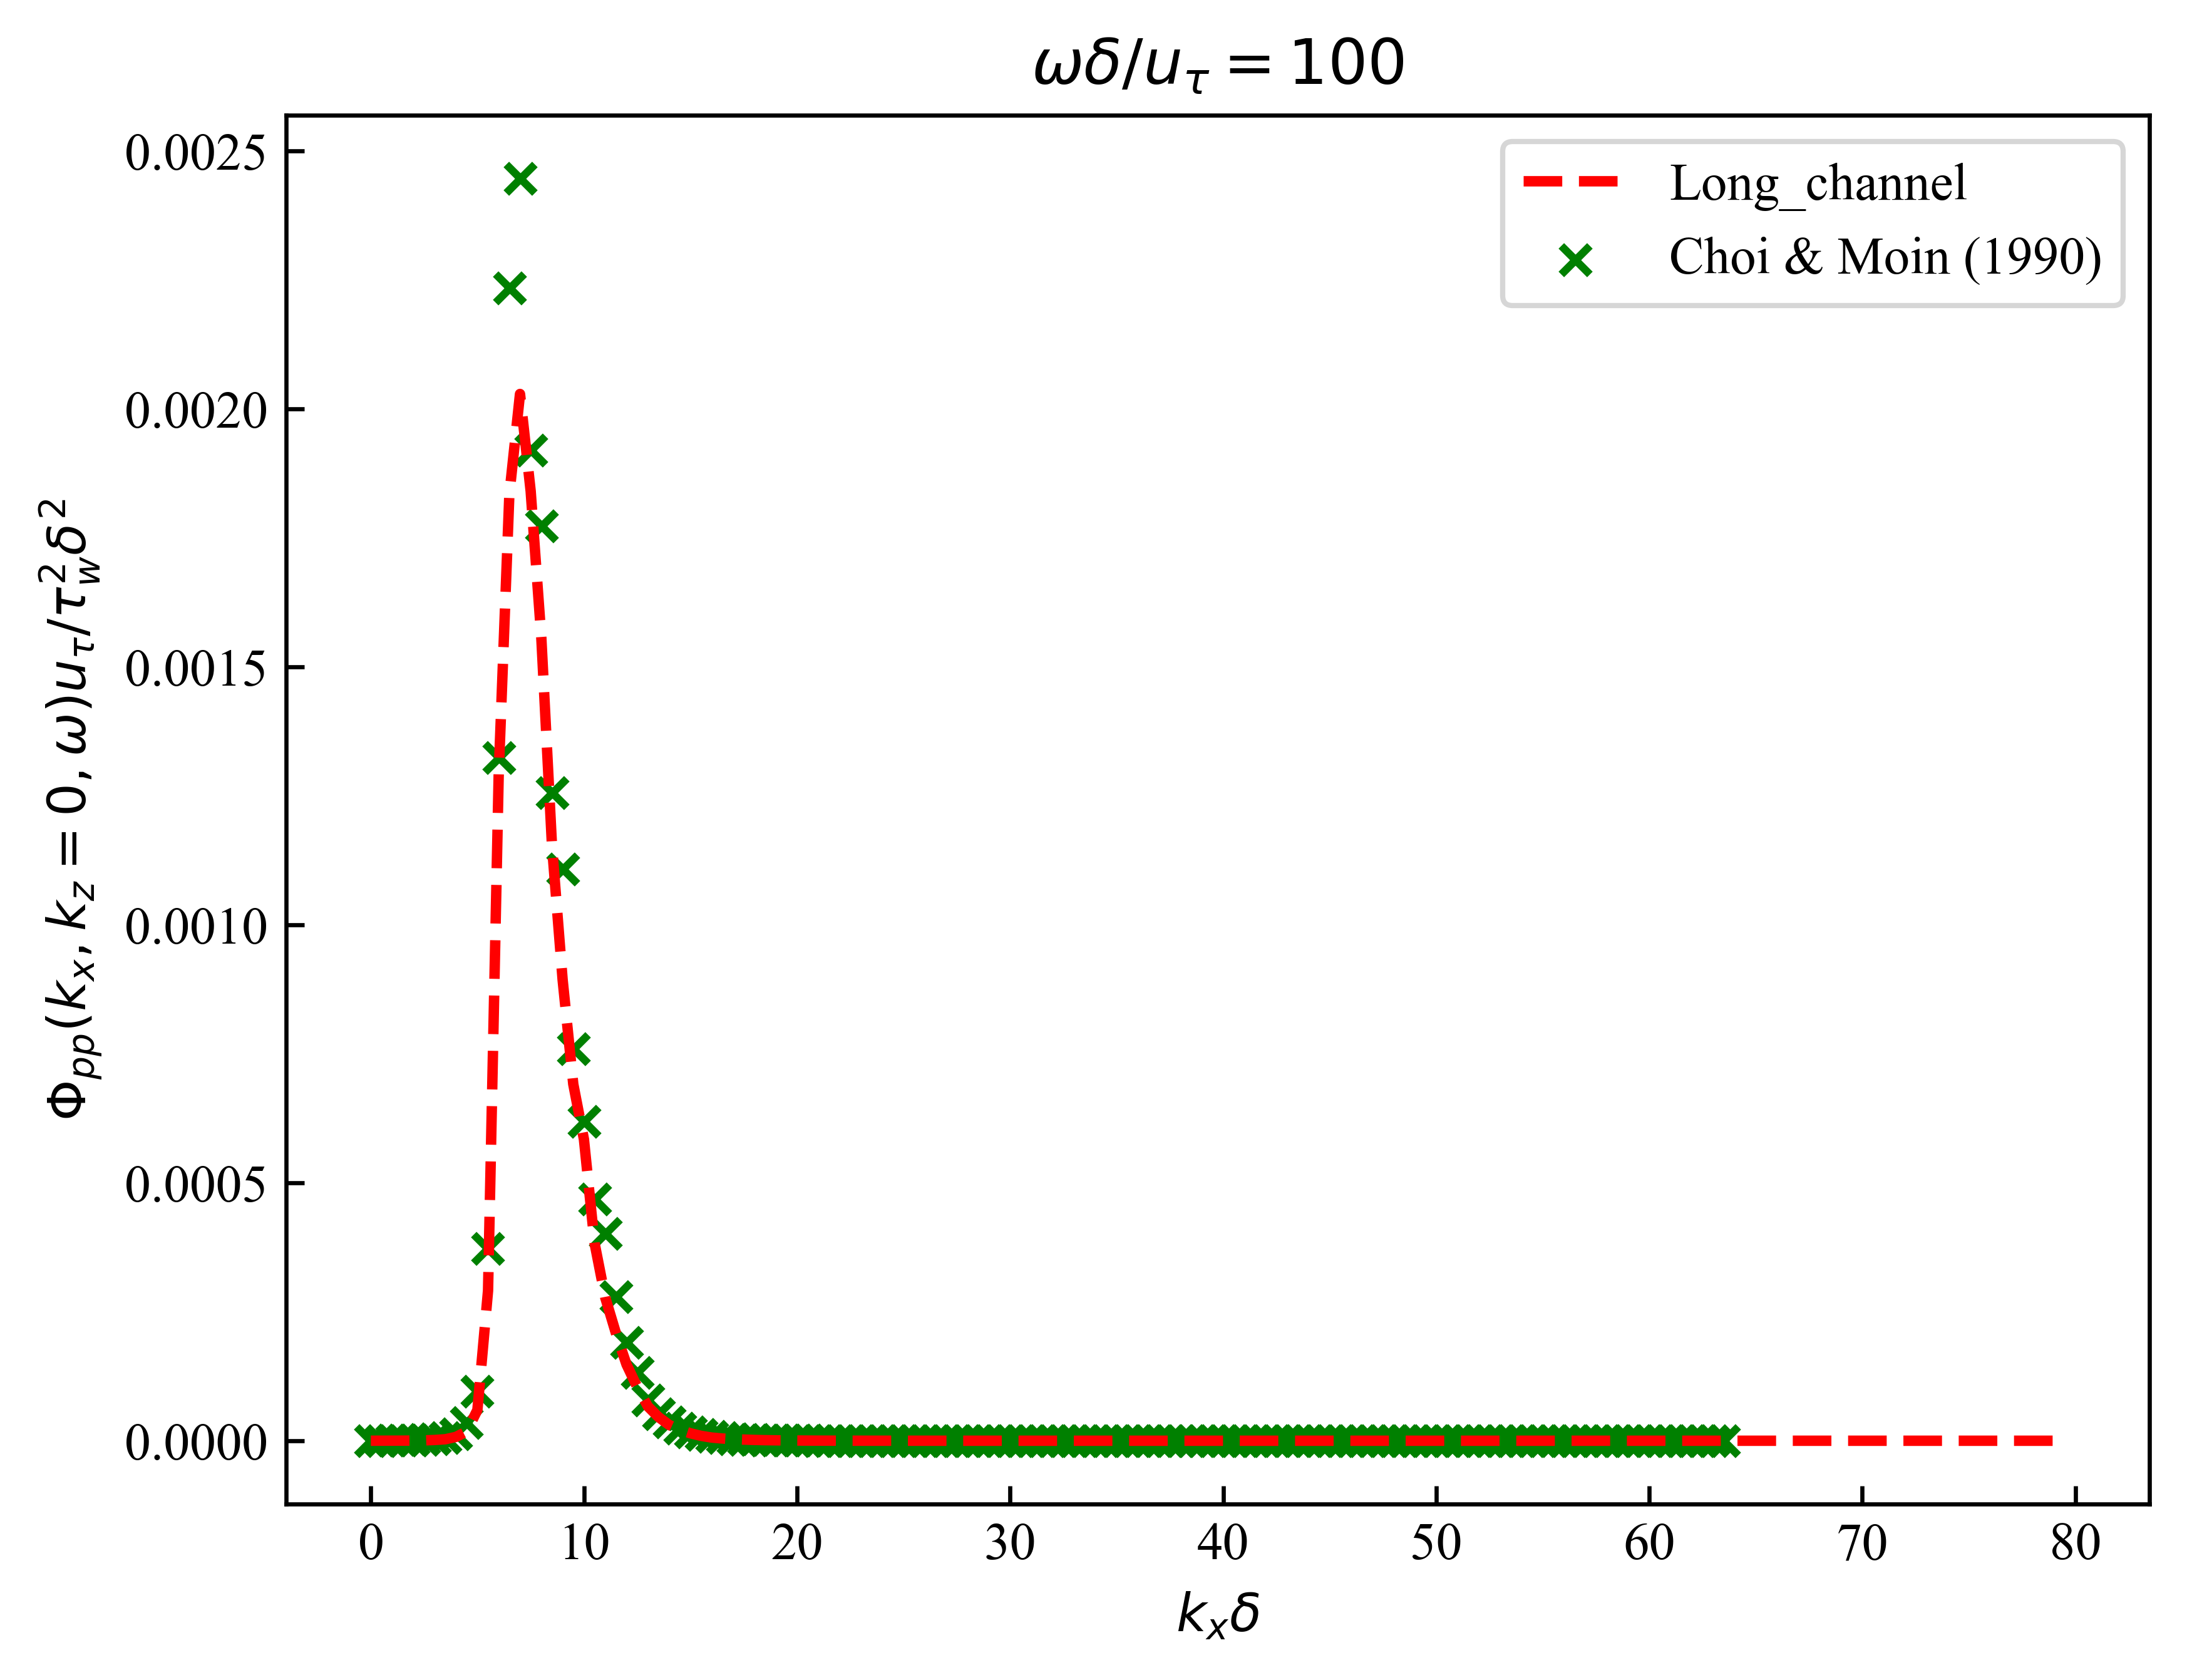

In [30]:
ref_x_t = np.loadtxt('/home/xiantao/code/NNwall/Diff-FSI/example/wall_pressure/2D_kx_w_180_at_100.txt')
f_x_t_ref, P_x_t_ref = ref_x_t[:,0], ref_x_t[:,1]

incompre_t = np.load(data_fold+'/p_x_t_100.npy')

plt.figure(dpi=600)
# plt.plot(incompre_t[0],  incompre_t[1],  color='blue',linewidth=2,label='Incompressible')
plt.plot(f_x_n,np.flip(P_x_t_n * 2,axis=0)[t_index_i,:nx//2],'--',color='red',linewidth=2,label='Long_channel')
plt.scatter(f_x_t_ref,P_x_t_ref,marker='x',color='green',s=30,label='Choi & Moin (1990)')
# plt.axvline(x=10, color='black', linestyle='--')
plt.xlabel(r'$k_x \delta$')
plt.ylabel(r'$\Phi_{pp}(k_x,k_z=0,\omega) u_{\tau}/\tau^2_w \delta^2$')
plt.title(r'$\omega \delta / u_{\tau} = 100$')
plt.legend()
plt.show()

In [24]:
# flip the P_x_t_n
P_x_t_z0 = jnp.mean(jnp.sum(pressure_power_spectrum[...,0:1],axis=-1)*diff.delta_kz, axis=0)
P_x_t_n_flip_z0 = jnp.flip(P_x_t_z0,axis=0)
P_x_t_n_flip_z0=P_x_t_n_flip_z0*u_tau/(tau_w**2)

In [25]:
x=[  4, 50, 110, 200, 300, 400]
t_index=[]
for x_i in x:
    difference_array = np.absolute(f_t_n-x_i)
    t_index.append( difference_array.argmin())

<function matplotlib.pyplot.show(close=None, block=None)>

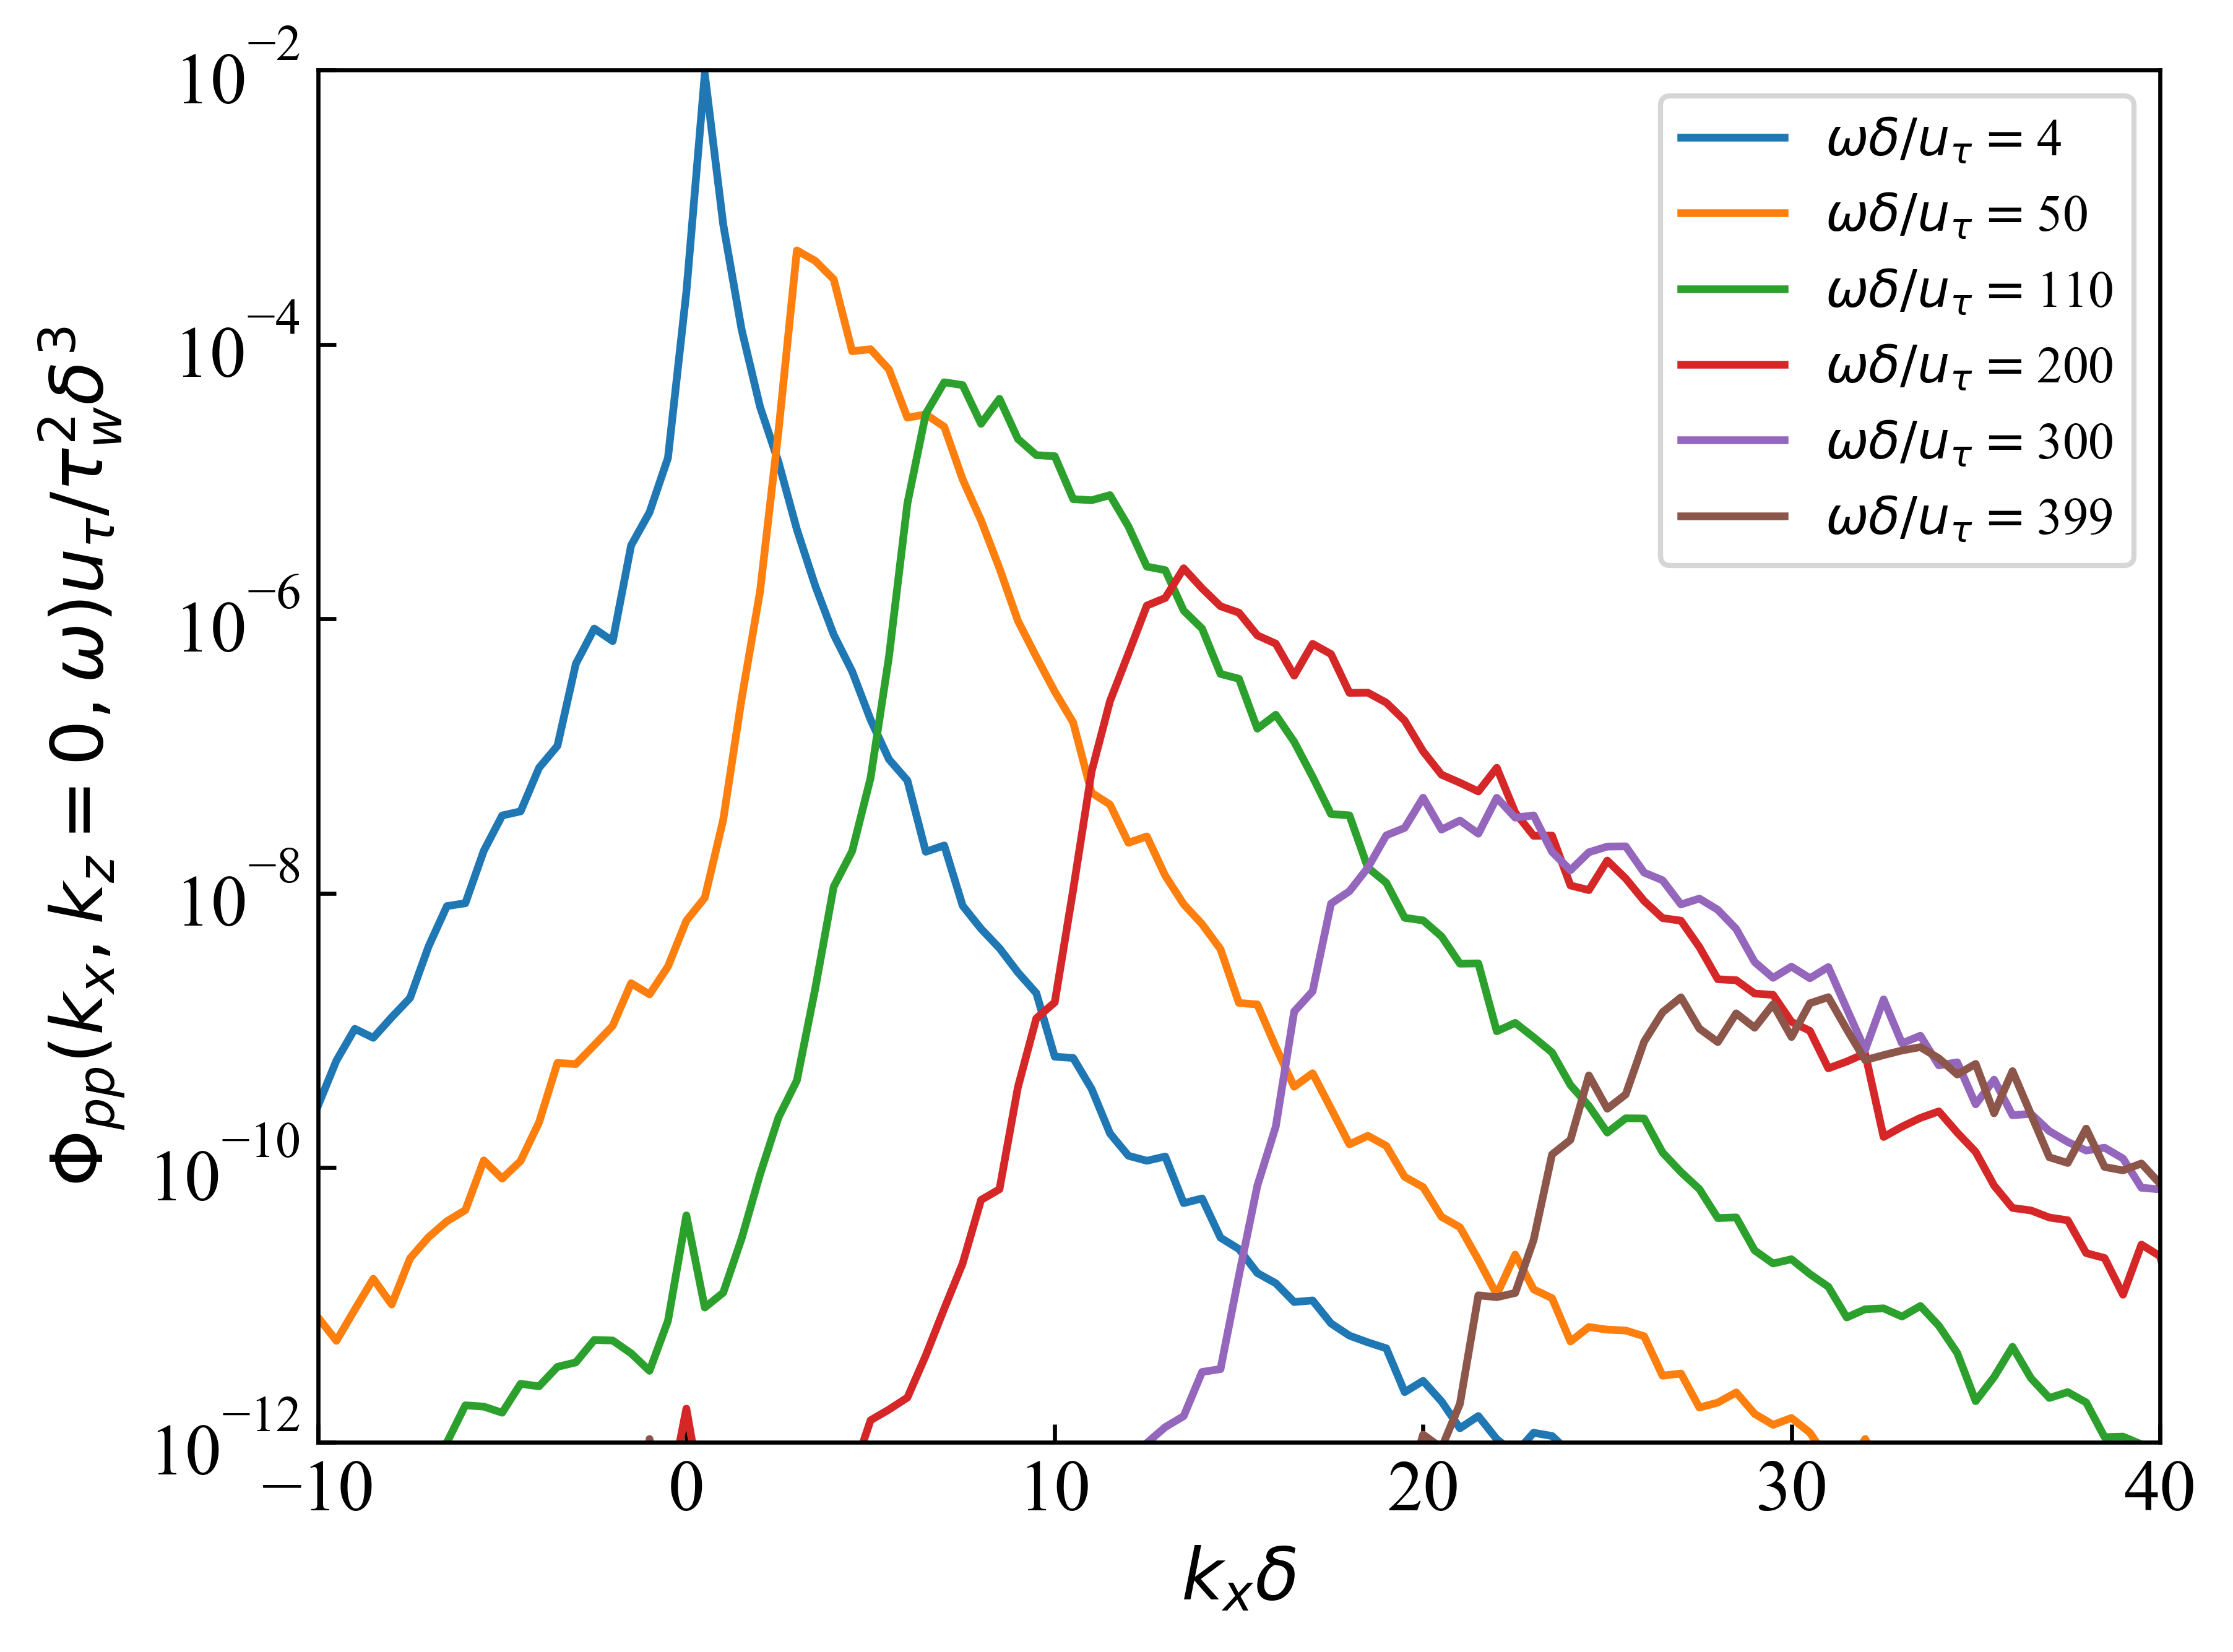

In [26]:
fx_all=jnp.fft.fftfreq(nx,dx)*2*np.pi

hfont = {'fontname':'Times New Roman'}
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.figure(dpi=600)
for t in t_index:
    plt.plot(jnp.fft.fftshift(fx_all),jnp.fft.fftshift(P_x_t_n_flip_z0[t]),label=r'$\omega \delta / u_{\tau}=$'+'%.0f'%(np.around(f_t_n[t])))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_x \delta$',fontsize = 14,**hfont)
plt.ylabel(r'$\Phi_{pp}(k_x,k_z=0,\omega) u_{\tau}/\tau^2_w \delta^3$',fontsize = 14,**hfont)
plt.legend()
plt.xlim([-10,40])
plt.ylim([1e-12,1e-2])
plt.xticks(fontsize=14,**hfont)
plt.yticks(fontsize=14,**hfont)
# plt.title('Re_tau=180')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

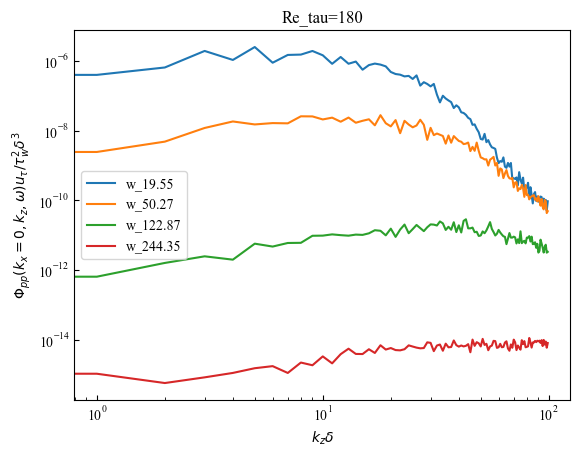

In [27]:
P_x_t_x0 = jnp.mean(jnp.sum(pressure_power_spectrum[...,0:1,:],axis=2)*diff.delta_kx, axis=0)
P_x_t_n_flip_x0 = jnp.flip(P_x_t_x0,axis=0)
P_x_t_n_flip_x0=P_x_t_n_flip_x0*u_tau/(tau_w**2)


z=[ 20, 50, 123, 245]
t_indez=[]
for z_i in z:
    difference_array = np.absolute(f_t_n-z_i)
    t_indez.append( difference_array.argmin())

plt.figure()
for t in t_indez:
    plt.plot(f_z_n,P_x_t_n_flip_x0[t,:nz//2],label='w_%.2f'%(f_t_n[t]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_z \delta$')
plt.ylabel(r'$\Phi_{pp}(k_x=0,k_z,\omega) u_{\tau}/\tau^2_w \delta^3$')
plt.legend()
# plt.xlim([10,200])
# plt.ylim([1e-18,1e-10])
plt.title('Re_tau=180')
plt.show